## Head

In [1]:
import os
import sys
import pandas as pd
import dask.dataframe as dd
import sidetable
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
import importlib

In [4]:
from typing import List, Dict, Union

In [5]:
import lightgbm as lgb

In [6]:
import causalml
import causalml.metrics as cmetrics
import causalml.inference.tree as ctree
import causalml.inference.meta.rlearner as rlearner

- Цена 1 г фисштеха равна 80 оренам. Себестоимость равна 52 оренам
- Отправка одного сообщения вороном стоит 1 орен
- покупатель не приобретает фисштех больше одного раза в день

## Lib

In [7]:
import sys
sys.path.append('../')
import featurelib as fl

In [8]:
def dask_groupby(
    data: dd.DataFrame,
    by: List[str],
    config: Dict[str, Union[str, List[str]]]
) -> dd.DataFrame:
    data_ = data.copy()
    dask_agg_config = dict()

    for col, aggs in config.items():
        aggs = aggs if isinstance(aggs, list) else [aggs]
        for agg in aggs:
            fictious_col = f'{col}_{agg}'
            data_ = data_.assign(**{fictious_col: lambda d: d[col]})
            dask_agg_config[fictious_col] = agg

    result = data_.groupby(by=by).agg(dask_agg_config)
    return result


In [9]:
class ReceiptsBasicFeatureCalcer(fl.DateFeatureCalcer):
    name = 'receipts_basic'
    keys = ['customer_id']

    def __init__(self, delta: int, **kwargs):
        self.delta = delta
        super().__init__(**kwargs)

    def compute(self) -> dd.DataFrame:
        receipts = self.engine.get_table('receipts')
        
        date_from = self.date_to - self.delta
        date_mask = (receipts['date'] >= date_from) & (receipts['date'] < self.date_to)

        features = receipts.loc[date_mask]
        features = dask_groupby(
            features,
            by=['customer_id'],
            config={
                "purchase_sum": ["sum", "max", "min", "mean"],
                "discount": ["sum"],
                "date": ["min", "max", "count"],
            }
        )
        features = (
            features
            .assign(
                mean_time_interval=lambda d: (
                    (d['date_max'] - d['date_min']) / (d['date_count'] - 1)
                )
            )
            .assign(time_since_last=lambda d: self.date_to - d['date_max'])
        )

        features = features.reset_index()
        features = features.rename(columns={
            col: col + f'__{self.delta}d' for col in features.columns if col not in self.keys
        })

        return features

In [10]:
class AgeGeoCalcer(fl.FeatureCalcer):
    name = 'age_geo'
    keys = ['customer_id']

    def compute(self) -> dd.DataFrame:
        customers_info = self.engine.get_table('customers')
        return customers_info[self.keys + ['age', 'location']]

In [11]:
class CampaignInfoCalcer(fl.DateFeatureCalcer):
    name = 'campaigns_info'
    keys = ['customer_id']
    
    def compute(self) -> dd.DataFrame:
        campaigns = self.engine.get_table('campaigns')
        date_mask = campaigns['date'] == self.date_to

        result = (
            self.engine.get_table('campaigns')
            .loc[date_mask]
            [[
                'customer_id',
                'n_offer_days', 'target_group_flag', 'date'
            ]]
            .rename(columns={'date': 'campaign_date'})
        )
        return result


In [12]:
fl.register_calcer(ReceiptsBasicFeatureCalcer)
fl.register_calcer(AgeGeoCalcer)
fl.register_calcer(CampaignInfoCalcer)

## Load'n'cook

In [13]:
engine = fl.Engine(tables={
    'receipts': dd.read_parquet('../data/final/receipts.parquet'),
    'customers': dd.read_csv('../data/final/customers.csv'),
    'campaigns': dd.read_csv('../data/final/campaigns.csv'),
})

### train

#### load

In [14]:
calcers_config = [
    {
        'name': 'receipts_basic',
        'args': {
            'date_to': 102, 'delta': 5
        }
    },
    {
        'name': 'receipts_basic',
        'args': {
            'date_to': 102, 'delta': 15
        }
    },
    {
        'name': 'receipts_basic',
        'args': {
            'date_to': 102, 'delta': 50
        }
    },
    {
        'name': 'receipts_basic',
        'args': {
            'date_to': 102, 'delta': 100
        }
    },
    { # target period
        'name': 'receipts_basic',
        'args': {
            'date_to': 132, 'delta': 30
        }
    },
    { # offer period
        'name': 'receipts_basic',
        'args': {
            'date_to': 109, 'delta': 7
        }
    },
    {
        'name': 'age_geo',
        'args': {}
    },
    {
        'name': 'campaigns_info',
        'args': {'date_to': 102}
    }
]

In [15]:
raw_data_train = fl.compute_features(engine, features_config=calcers_config)

In [16]:
raw_data_train = raw_data_train.compute()

In [17]:
raw_data_train.shape

(2000000, 66)

#### transform

In [18]:
def fix_column_names(data: pd.DataFrame) -> pd.DataFrame:
    for _days in [30, 7]:
        for col_name in [
            f'purchase_sum_sum__{_days}d',
            f'purchase_sum_max__{_days}d',
            f'purchase_sum_min__{_days}d',
            f'purchase_sum_mean__{_days}d',
            f'discount_sum__{_days}d',
            f'date_min__{_days}d',
            f'date_max__{_days}d',
            f'date_count__{_days}d',
            f'mean_time_interval__{_days}d',
            f'time_since_last__{_days}d'
        ]:
            data = data.rename(columns={col_name: 'target__' + col_name})
    return data

In [19]:
MARGIN_RATE = 0.35
MESSAGE_COST = 1.0


def _transform(data: pd.DataFrame) -> pd.DataFrame:
    data.fillna({'target_group_flag': 0}, inplace=True)
    data['target_profit'] = (
        MARGIN_RATE * data['target__purchase_sum_sum__30d'].fillna(0.0)
        - MESSAGE_COST * data['target_group_flag'].fillna(0)
        - data['target__discount_sum__30d'].fillna(0)
    )
    return data

In [20]:
data_train = fix_column_names(raw_data_train)
data_train = _transform(data_train)

In [21]:
data_train.head()

,customer_id,purchase_sum_sum__5d,purchase_sum_max__5d,purchase_sum_min__5d,purchase_sum_mean__5d,discount_sum__5d,date_min__5d,date_max__5d,date_count__5d,mean_time_interval__5d,...,target__date_max__7d,target__date_count__7d,target__mean_time_interval__7d,target__time_since_last__7d,age,location,n_offer_days,target_group_flag,campaign_date,target_profit
0,11,1487.705672,1487.705672,1487.705672,1487.705672,0.0,100.0,100.0,1.0,NaN,...,NaN,NaN,NaN,NaN,57,Novigrad,7.0,1.0,102.0,753.619862
1,13,1079.160515,1079.160515,1079.160515,1079.160515,0.0,101.0,101.0,1.0,NaN,...,NaN,NaN,NaN,NaN,63,Kaer_Trolde,7.0,1.0,102.0,-1.000000
2,18,2784.746810,2784.746810,2784.746810,2784.746810,0.0,97.0,97.0,1.0,NaN,...,NaN,NaN,NaN,NaN,64,Kaer_Trolde,7.0,1.0,102.0,586.967591
3,19,1215.343668,1215.343668,1215.343668,1215.343668,0.0,100.0,100.0,1.0,NaN,...,104.0,2.0,2.0,5.0,25,Novigrad,7.0,1.0,102.0,1830.142625
4,22,943.251812,943.251812,943.251812,943.251812,0.0,97.0,97.0,1.0,NaN,...,105.0,1.0,NaN,4.0,36,Hindarsfjall,7.0,1.0,102.0,1246.848085


#### splits

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
fit_index, val_index = train_test_split(data_train.index, test_size=0.5, random_state=165)

### serve

#### load

In [24]:
calcers_config = [
    {
        'name': 'receipts_basic',
        'args': {
            'date_to': 250, 'delta': 5
        }
    },
    {
        'name': 'receipts_basic',
        'args': {
            'date_to': 250, 'delta': 15
        }
    },
    {
        'name': 'receipts_basic',
        'args': {
            'date_to': 250, 'delta': 50
        }
    },
    {
        'name': 'receipts_basic',
        'args': {
            'date_to': 250, 'delta': 100
        }
    },
#     { # target period
#         'name': 'receipts_basic',
#         'args': {
#             'date_to': 132, 'delta': 30
#         }
#     },
#     { # offer period
#         'name': 'receipts_basic',
#         'args': {
#             'date_to': 109, 'delta': 7
#         }
#     },
    {
        'name': 'age_geo',
        'args': {}
    },
#     {
#         'name': 'campaigns_info',
#         'args': {'date_to': 102}
#     }
]

In [25]:
raw_data_serve = fl.compute_features(engine, features_config=calcers_config)

In [26]:
raw_data_serve = raw_data_serve.compute()

In [27]:
raw_data_serve.shape

(2000000, 43)

#### transform

In [28]:
data_serve = fix_column_names(raw_data_serve)

### column sets

In [29]:
cols_features_n1 = [
    'date_count__100d',
    'purchase_sum_sum__100d',
    'purchase_sum_max__100d',
    'purchase_sum_min__100d',
    'purchase_sum_mean__100d',
    'mean_time_interval__100d',
    'time_since_last__100d',
    'date_count__5d',
    'purchase_sum_sum__5d',
    'purchase_sum_max__5d',
    'purchase_sum_min__5d',
    'purchase_sum_mean__5d',
    'mean_time_interval__5d',
    'age'
]

## Main

### EDA

In [30]:
data_train.loc[fit_index].groupby(by=['target_group_flag']).agg({
    'target_profit': 'mean',
    'target__purchase_sum_sum__30d': 'mean',
    'target__discount_sum__30d': 'mean',
    'customer_id': 'count',
})

,target_profit,target__purchase_sum_sum__30d,target__discount_sum__30d,customer_id
target_group_flag,,,,
0.0,877.656473,3087.472949,0.000000,1499361
1.0,874.963284,3083.327417,21.905052,500083


In [31]:
data_train.stb.missing()

,missing,total,percent
mean_time_interval__5d,1970933,2000000,98.54665
target__mean_time_interval__7d,1922763,2000000,96.13815
n_offer_days,1500000,2000000,75.00000
campaign_date,1500000,2000000,75.00000
mean_time_interval__15d,1499398,2000000,74.96990
...,...,...,...
target_group_flag,0,2000000,0.00000
customer_id,0,2000000,0.00000
location,0,2000000,0.00000
age,0,2000000,0.00000


### model

In [32]:
col_target = 'target_profit'
col_treatment = 'target_group_flag'

In [33]:
cols_features = cols_features_n1

In [34]:
model_n1 = rlearner.BaseRRegressor(
    learner=lgb.LGBMRegressor(),
    control_name=0,
    n_fold=4,
    random_state=165
)

In [36]:
len(fit_index)

1000000

In [59]:
_p_score_const = data_train.loc[fit_index, col_treatment].value_counts(normalize=True).loc[1]
_p_scores = pd.Series(data=_p_score_const, index=fit_index)
model_n1.fit(
    X=data_train.iloc[fit_index].loc[:,cols_features].fillna(0).values,
    treatment=data_train.iloc[fit_index].loc[:,col_treatment].values,
    y=data_train.iloc[fit_index].loc[:,col_target].values,
    p=_p_scores
)

#### evaluate model

In [60]:
_eval_data = data_train.iloc[val_index].loc[:, cols_features + [col_treatment, col_target]]
_eval_data['score'] = model_n1.predict(_eval_data[cols_features])
_eval_data = _eval_data[['score', col_treatment, col_target]]

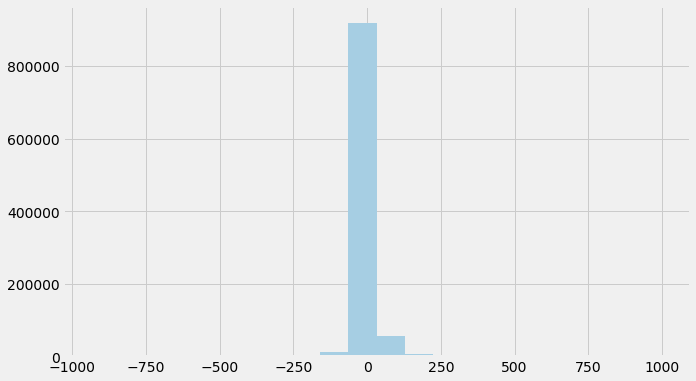

In [61]:
plt.figure(figsize=(10, 6))
plt.hist(_eval_data['score'], bins=20)
plt.show()

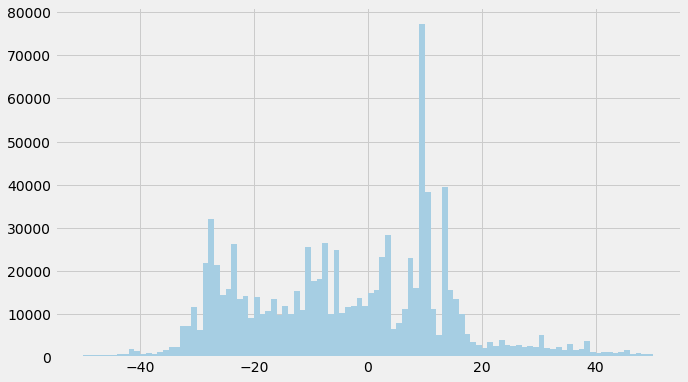

In [62]:
plt.figure(figsize=(10, 6))
plt.hist(_eval_data['score'], bins=100, range=(-50, 50))
plt.show()

In [63]:
np.percentile(_eval_data['score'], 5)

-31.249961337362432

In [64]:
np.percentile(_eval_data['score'], 95)

38.4425324978422

In [65]:
_eval_data['score'].describe()

count    1000000.000000
mean          -2.042876
std           36.629920
min         -934.262402
25%          -19.524706
50%           -2.838634
75%            9.922089
max          997.870561
Name: score, dtype: float64

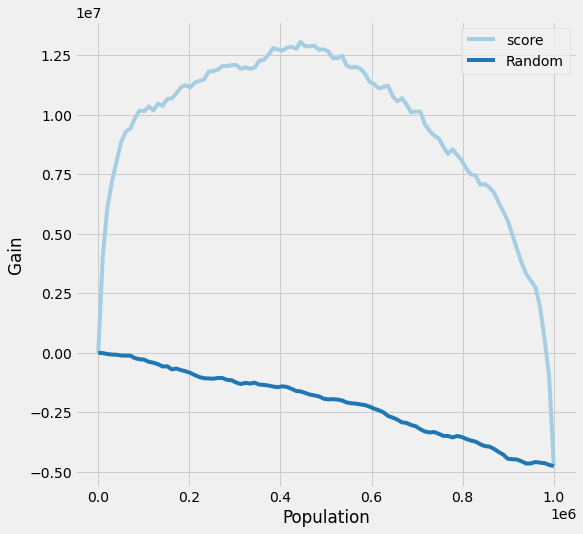

In [66]:
cmetrics.plot_gain(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col=col_target,
)

### decisions

In [67]:
data_serve['model_n1_pred'] = model_n1.predict(data_serve[cols_features_n1])

In [68]:
data_serve['model_n1_pred'].describe()

count    2.000000e+06
mean    -2.024943e+00
std      3.659533e+01
min     -9.873743e+02
25%     -1.961459e+01
50%     -2.860439e+00
75%      9.922089e+00
max      9.364955e+02
Name: model_n1_pred, dtype: float64

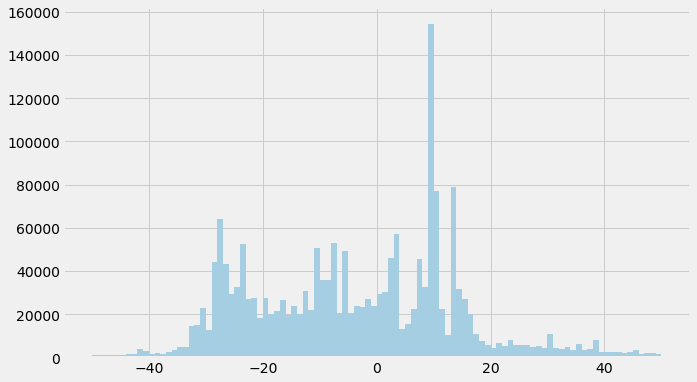

In [69]:
plt.figure(figsize=(10, 6))
plt.hist(data_serve['model_n1_pred'], bins=100, range=(-50, 50))
plt.show()

In [70]:
(data_serve['model_n1_pred'] > 5.0).mean()

0.3806555

In [71]:
data_serve[data_serve['model_n1_pred'] > 5.0]['customer_id'].to_csv('submission_n1.csv', index=None)